### Load Library 

In [1]:
import import_ipynb

In [2]:
import proj2_lib as lib
lib.pd.set_option('display.max_colwidth' , -1) #Display full width for all cell
lib.pd.set_option('display.max_columns', 500)

importing Jupyter notebook from proj2_lib.ipynb
Wall time: 0 ns
Lib Loaded


### Read data

In [7]:
#Read data  , 494021
df = lib.pd.read_csv("network_intrusion_data.csv" , na_values=['NA','?'] , names=lib.get_real_column())

In [8]:
#Drop duplicates , 145586
df.drop_duplicates(inplace = True)

### Filter Column  /Extract Important Feature

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Intercept: [ 2.79246976 -1.5180688  -1.84020479 -1.53626764 -1.71659291  0.66850558
 -2.17310329 -1.88724008 -2.08982507  4.42960224  0.89998255  6.28466225
 -2.18959968 -2.13783144  1.07123327  0.60660803 -1.80523654  1.34350744
  1.20185633  0.20048257  1.38026799 -1.98520778]


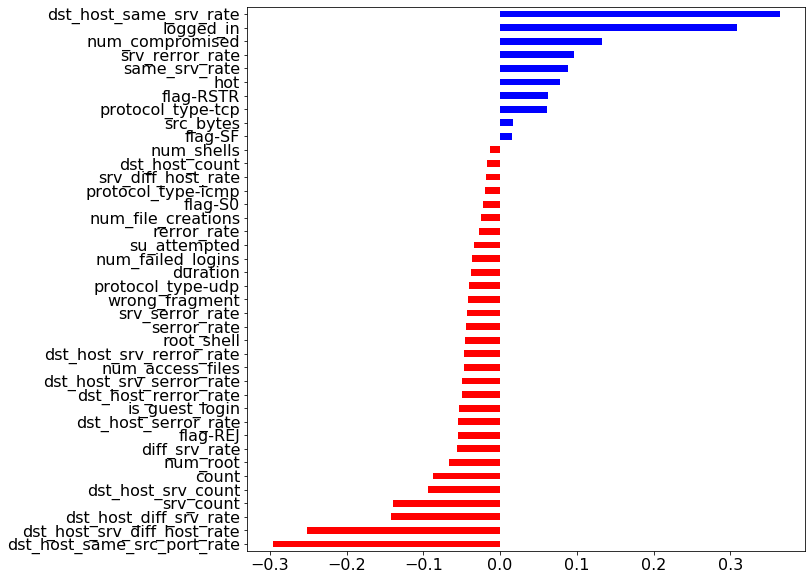

In [9]:
df, attacks = lib.grab_important_feature(df)

In [10]:
df.shape #34 Features 

(145586, 41)

In [11]:
attacks

array(['back.', 'buffer_overflow.', 'ftp_write.', 'guess_passwd.',
       'imap.', 'ipsweep.', 'land.', 'loadmodule.', 'multihop.',
       'neptune.', 'nmap.', 'normal.', 'perl.', 'phf.', 'pod.',
       'portsweep.', 'rootkit.', 'satan.', 'smurf.', 'spy.', 'teardrop.',
       'warezclient.', 'warezmaster.'], dtype=object)

In [12]:
# Before balance 
df.groupby(['outcome']).outcome.count()

outcome
0     968  
1     30   
2     8    
3     53   
4     12   
5     651  
6     19   
7     9    
8     7    
9     51820
10    158  
11    87832
12    3    
13    4    
14    206  
15    416  
16    10   
17    906  
18    641  
19    2    
20    918  
21    893  
22    20   
Name: outcome, dtype: int64

In [13]:
df = lib.balance_it(df)

outcome
0     968 
5     651 
9     1000
10    158 
11    1000
14    206 
15    416 
17    906 
18    641 
20    918 
21    893 
Name: outcome, dtype: int64


### Train_Test_Split

In [14]:
# Prepare x , y
x,y = lib.to_xy(df,'outcome')

In [15]:
# Split x,y
x_train, x_test, y_train, y_test = lib.train_test_split(x, y, test_size=0.25, stratify=y) 

### (Neural Network) Create Model  and Training 

In [12]:
%%time 
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Create Checkpoint to save best result
checkpointer = lib.ModelCheckpoint(filepath='saved/network_best_weight.hdf5', verbose=0, save_best_only=True)

for i in range(20):
    print(i)
    # Create empty model 
    model = Sequential()

    #Add layers 
    model.add(Dense(128, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(25, activation='relu')) #25
    model.add(Dense(15, activation='relu')) # None
    model.add(Dense(y.shape[1], activation='softmax'))

    #Function to use as Loss function and Gradient Descent 
    model.compile(loss='categorical_crossentropy' , optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')

    #Train model 
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=1000)

#Load best weights from model 
model.load_weights('saved/network_best_weight.hdf5')
print("Best Model Loaded....")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Best Model Loaded....
Wall time: 3min 6s


In [18]:
pred = model.predict(x_test)

In [19]:
df2 = lib.pd.DataFrame(attacks , columns=["attType"])

In [20]:
df2.drop([1,2,3,4,6,7,8,12,13,16,19,22])

,attType
0,back.
5,ipsweep.
9,neptune.
10,nmap.
11,normal.
14,pod.
15,portsweep.
17,satan.
18,smurf.
20,teardrop.


In [22]:
v = lib.np.array(df2.attType)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       242
           1       0.99      0.99      0.99       163
           2       1.00      1.00      1.00       250
           3       0.93      0.97      0.95        39
           4       1.00      0.97      0.98       250
           5       1.00      1.00      1.00        52
           6       1.00      1.00      1.00       104
           7       1.00      1.00      1.00       227
           8       1.00      1.00      1.00       160
           9       1.00      1.00      1.00       230
          10       0.99      1.00      0.99       223

    accuracy                           0.99      1940
   macro avg       0.99      0.99      0.99      1940
weighted avg       0.99      0.99      0.99      1940

[[241   0   0   0   1   0   0   0   0   0   0]
 [  0 162   0   1   0   0   0   0   0   0   0]
 [  0   0 250   0   0   0   0   0   0   0   0]
 [  0   1   0  38   0   0   0   0   0   0   0]

<Figure size 432x288 with 0 Axes>

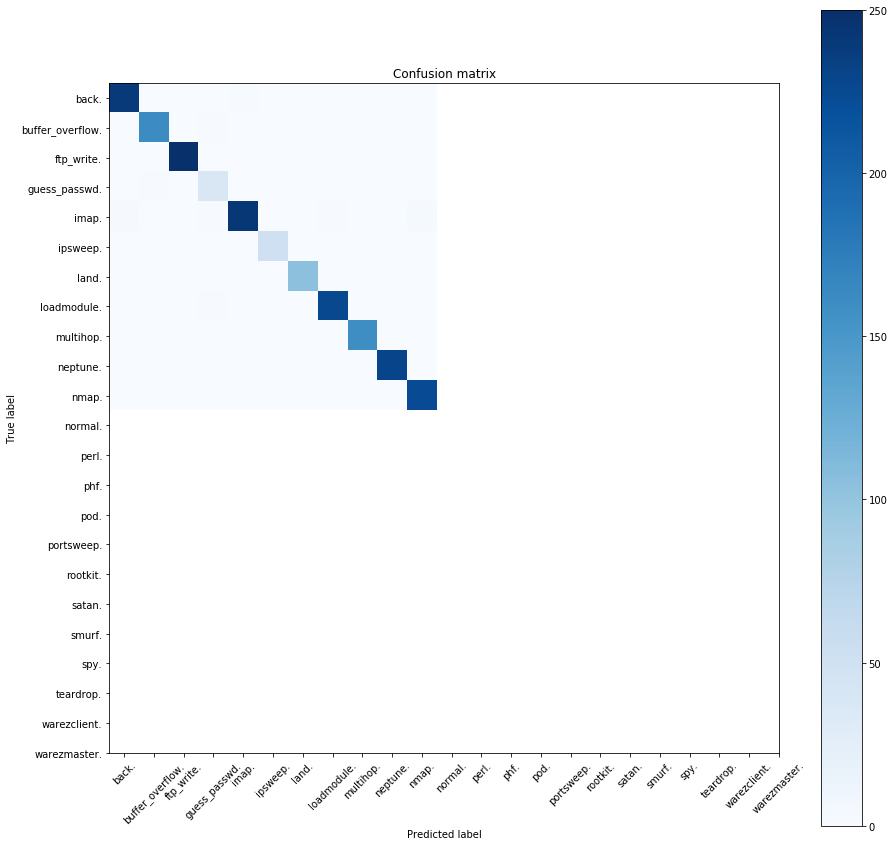

In [23]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report


#Since softmax is used.. we need to get the largest number probabilty for each row 
predict_classes = lib.np.argmax(pred,axis=1) # get max from each row in pred 
true_classes = lib.np.argmax(y_test,axis=1)
print(lib.metrics.classification_report(true_classes, predict_classes))

# Compute confusion matrix
cm = confusion_matrix(true_classes, predict_classes)
print(cm)

print('Plotting confusion matrix')
lib.plt.figure()
lib.plot_confusion_matrix(cm,v )
lib.plt.show()

### (Deep Neural Network) Create Model  and Training 

In [28]:
# Load modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [29]:
# define input image dimensions
img_rows, img_cols = 1, x_train.shape[1]

#### Create x (image) 

In [30]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

In [31]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))

x_train shape: (5817, 1, 40, 1)
x_test shape: (1940, 1, 40, 1)
Training samples: 5817
Test samples: 1940


#### Create y

In [32]:
y_train.shape, y_test.shape

((5817, 11), (1940, 11))

#### Build Model

In [36]:
# DON"T RUN THIS !!!!!!!!!!! ONLY FOR DEMO PURPOSES !!!!!!!!!!!!!!
model = Sequential()
input_shape = (img_rows, img_cols, 1) 

model.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 3), padding='valid', activation='relu', input_shape=input_shape))    #  in this case, input_shape = (img_rows, img_cols, 1)  , valid padding means output shape might be smaller than input shape
model.add(Conv2D(64, (1, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
model.add(Dropout(0.25)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) #output layer 

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 8, 32)          128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 6, 64)          6208      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 3, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [20]:
x_train.shape

(5817, 1, 39, 1)

In [34]:
%%time
import time
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

input_shape = (img_rows, img_cols, 1)
#Create Checkpoint to save best result
checkpointer = lib.ModelCheckpoint(filepath='saved/network_best_weight_cnn.hdf5', verbose=0, save_best_only=True)

for i in range(100):
    print(i)
    #Empty Model
    model = Sequential()

    #Add Layers 
    model.add(Conv2D(32, kernel_size=(1, 15), strides=(1, 2), padding='valid', activation='relu', input_shape=input_shape))    #  in this case, input_shape = (img_rows, img_cols, 1)  , valid padding means output shape might be smaller than input shape
    model.add(Conv2D(64, (1, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 9), strides=None))
    model.add(Dropout(0.25)) 
    model.add(Flatten())
    model.add(Dense(150, activation='relu')) #128 
    model.add(Dropout(0.5))
    model.add(Dense(y_test.shape[1], activation='softmax')) #output layer 

    #Function to use as Loss function and Gradient Descent 
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

    #Train model 
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=1000)
    

    
#Load best weights from model 
model.load_weights('saved/network_best_weight_cnn.hdf5')
print("Best Model Loaded....")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Best Model Loaded....
Wall time: 29min 36s


Accuracy: 0.9902061855670103
Averaged F1: 0.9901981655933018
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       242
           1       0.99      0.98      0.99       163
           2       1.00      1.00      1.00       250
           3       0.90      0.97      0.94        39
           4       0.99      0.95      0.97       250
           5       1.00      1.00      1.00        52
           6       1.00      1.00      1.00       104
           7       1.00      1.00      1.00       227
           8       0.99      1.00      1.00       160
           9       1.00      1.00      1.00       230
          10       0.98      1.00      0.99       223

    accuracy                           0.99      1940
   macro avg       0.99      0.99      0.99      1940
weighted avg       0.99      0.99      0.99      1940

[[241   0   0   0   1   0   0   0   0   0   0]
 [  0 162   0   1   0   0   0   0   0   0   0]
 [  0   0 250   0   0   0   0   

<Figure size 432x288 with 0 Axes>

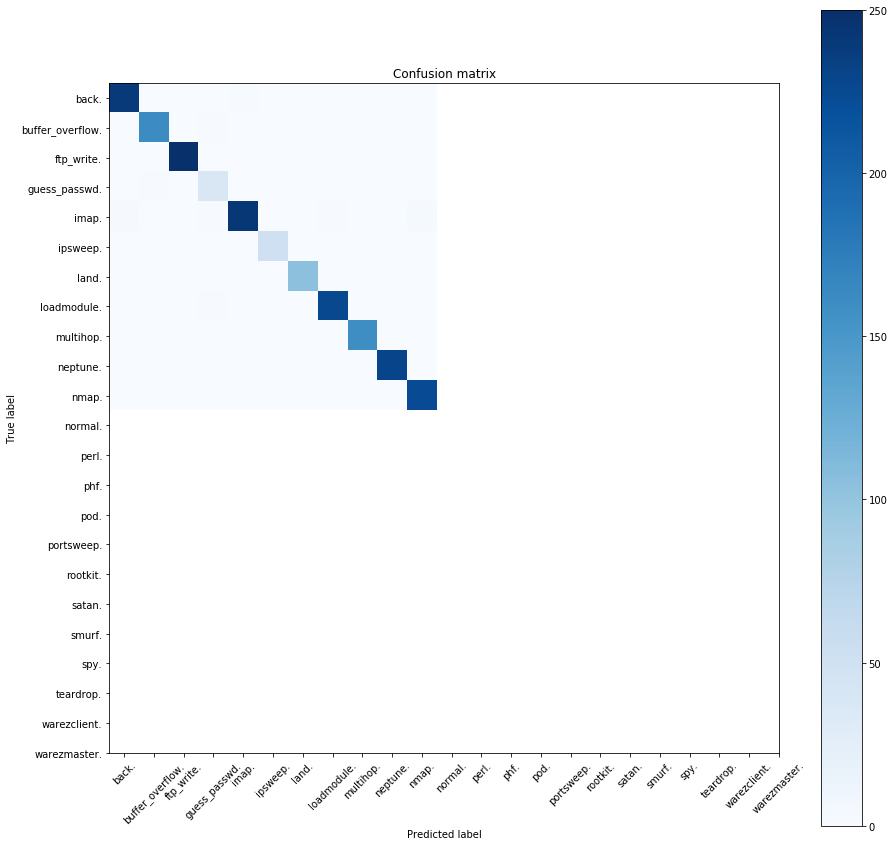

In [34]:
import numpy as np
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


y_true = lib.np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = lib.np.argmax(pred,axis=1)


score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

# Compute confusion matrix
cm = confusion_matrix(true_classes, predict_classes)
print(cm)

print('Plotting confusion matrix')
lib.plt.figure()
lib.plot_confusion_matrix(cm,v )
lib.plt.show()